#Exploratory Data Analysis (EDA)

## Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels as sm

In [ ]:
# decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
# stationary
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import ks_2samp
# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# for interactive plot
import ipywidgets as widgets
from ipywidgets import interact

In [ ]:
import ipykernel
ipykernel.version_info

(6, 17, 1)

## Data Load and Feature Computation

In [ ]:
time_df = yf.download('MSFT', start="2025-01-01", auto_adjust=True)
time_df.columns = [col[0] for col in time_df.columns]
time_df.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2025-01-02,415.514832,422.950005,411.812165,422.413951,16896500
2025-01-03,420.249908,420.924922,416.467811,417.996512,16662900
2025-01-06,424.716949,431.139572,422.364309,424.865845,20573600
2025-01-07,419.277069,427.496435,417.718559,425.858524,18139100
2025-01-08,421.451019,423.843375,418.453145,420.359068,15054600


In [ ]:
time_df['Return'] = time_df['Close'].pct_change()
time_df['LogReturn'] = np.log(time_df['Close'] / time_df['Close'].shift(1))
time_df.describe()

,Close,High,Low,Open,Volume,Return,LogReturn
count,275.000000,275.000000,275.000000,275.000000,2.750000e+02,274.000000,274.000000
mean,462.006641,465.954227,457.786620,462.080709,2.363917e+07,0.000011,-0.000128
std,49.381287,49.209839,49.977276,49.905301,1.160319e+07,0.016742,0.016754
min,352.669373,362.536482,342.951498,349.009021,5.855900e+06,-0.099931,-0.105284
25%,414.852417,421.262432,411.841934,417.028649,1.679275e+07,-0.007580,-0.007609
50%,477.179993,479.820007,472.417724,476.320007,2.095870e+07,0.000609,0.000609
75%,505.768387,509.132766,501.626146,504.953259,2.569410e+07,0.006425,0.006405
max,541.057373,553.502444,539.759814,553.283183,1.288553e+08,0.101337,0.096525


## General Data Exploration

### Diagnose date gaps

In [ ]:
time_df.index.diff().value_counts().head()

,count
Date,
1 days,212
3 days,50
4 days,7
2 days,5


In [ ]:
# df for gap vs jump relation
analysis_df = time_df.copy()
analysis_df['GapDays'] = analysis_df.index.to_series().diff().dt.days
analysis_df['AbsJumpInClose'] = analysis_df['Close'].diff().abs()
analysis_df = analysis_df.dropna()

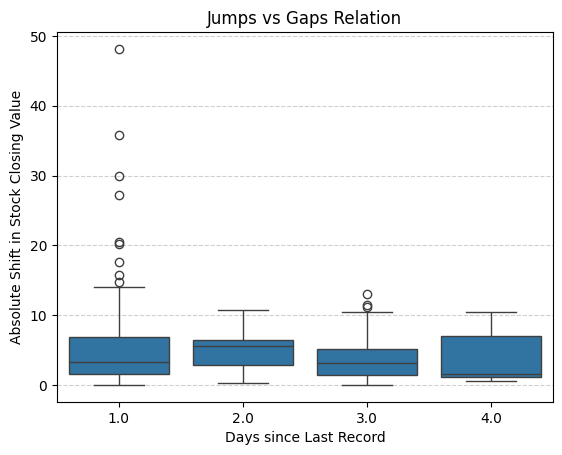

In [ ]:
sns.boxplot(data=analysis_df, x = 'GapDays', y = 'AbsJumpInClose')
plt.title('Jumps vs Gaps Relation')
plt.xlabel('Days since Last Record')
plt.ylabel('Absolute Shift in Stock Closing Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
analysis_df.groupby('GapDays')['AbsJumpInClose'].describe()

,count,mean,std,min,25%,50%,75%,max
GapDays,,,,,,,,
1.0,212.0,5.098738,5.885399,0.019958,1.634903,3.235001,6.868683,48.130005
2.0,5.0,5.179779,3.918208,0.309998,2.830017,5.568878,6.510010,10.679993
3.0,50.0,3.939963,3.389846,0.009949,1.499733,3.109146,5.098473,13.079895
4.0,7.0,4.119625,4.062462,0.526093,1.158630,1.567078,6.976913,10.473114


* The longer gaps (more than 1 day) doesn't affect the jumps, suggesting no abnormality in stock data.

* The consecutive days have higher volatility and are more concerning.

### Distribution

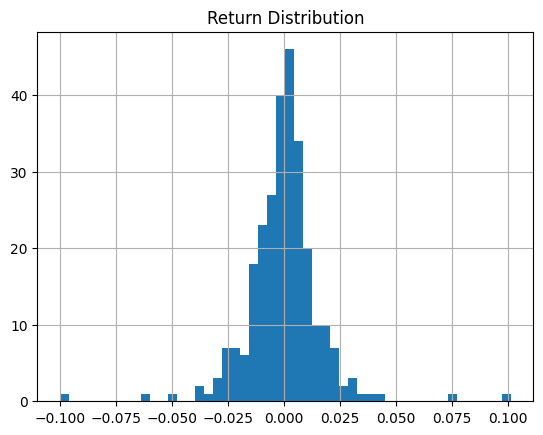

In [ ]:
time_df["Return"].hist(bins=50)
plt.title("Return Distribution")
plt.show()

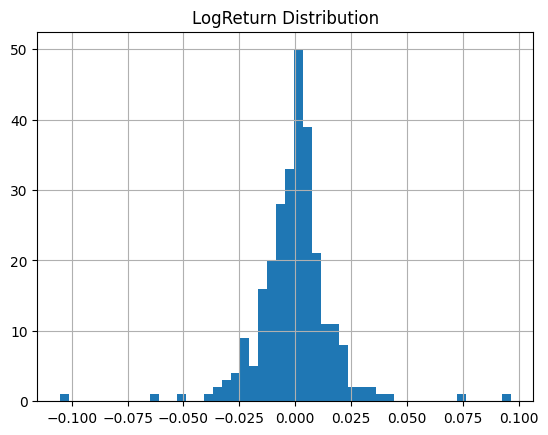

In [ ]:
time_df["LogReturn"].hist(bins=50)
plt.title("LogReturn Distribution")
plt.show()

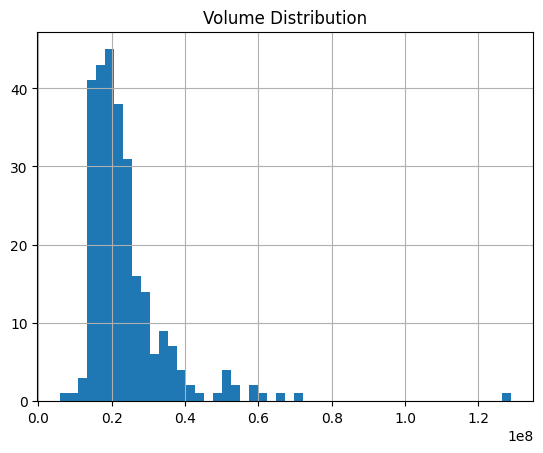

In [ ]:
time_df['Volume'].hist(bins=50)
plt.title('Volume Distribution')
plt.show()

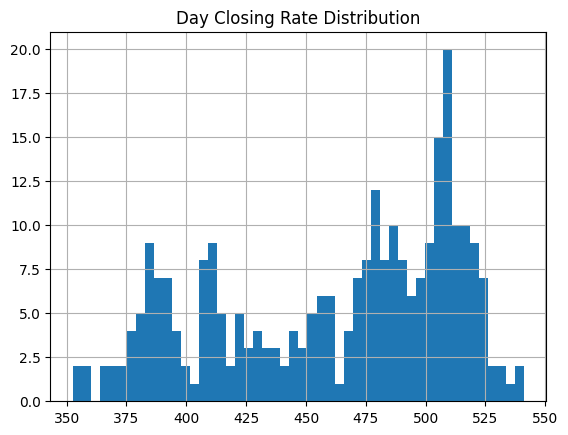

In [ ]:
time_df['Close'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

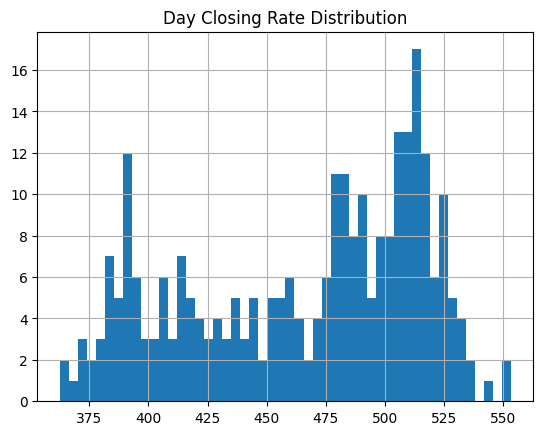

In [ ]:
time_df['High'].hist(bins=50)
plt.title('Day Closing Rate Distribution')
plt.show()

* Stock open and close price show multimodal distribution.
  * Tree-based (XGBoost, Random Forest) and Hidden Markov Model might work better than ARIMA or LSTM that work on sequencial data.
  * Feature Engineering may benefit in sequencial based models
* Return and log of retun show normal distribution.
* Volume shows positively skewed distribution

## Exploration Relevant to Forecast

### Decomposition


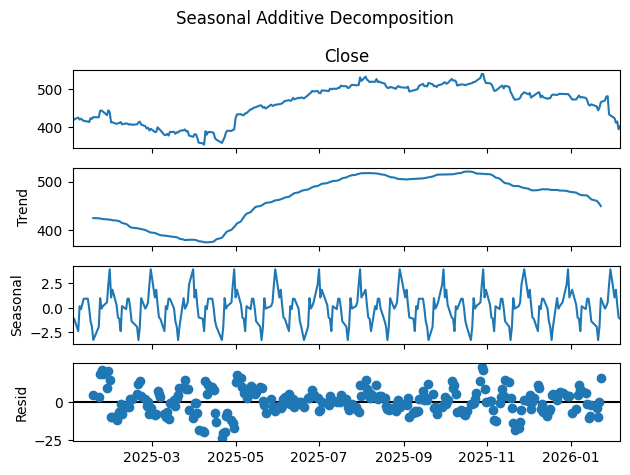

In [ ]:
decomp = seasonal_decompose(time_df['Close'], model='additive', period=21)
decomp.plot()
plt.suptitle('Seasonal Additive Decomposition')
plt.tight_layout()
plt.show()

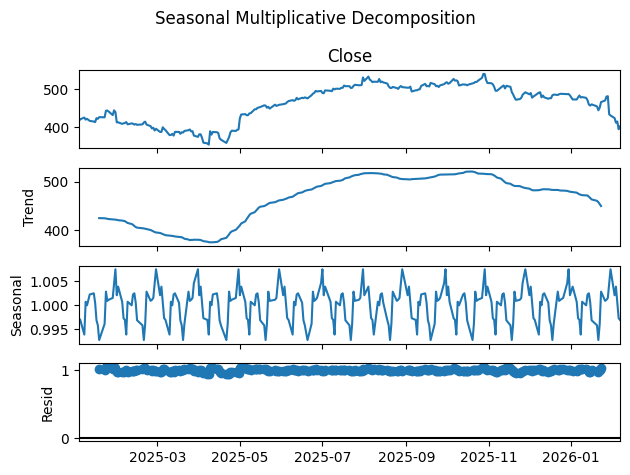

In [ ]:
decomp = seasonal_decompose(time_df['Close'], model='multiplicative', period=21)
decomp.plot()
plt.suptitle('Seasonal Multiplicative Decomposition')
plt.tight_layout()
plt.show()

In [ ]:
decomp.resid.describe()

,resid
count,255.000000
mean,1.000413
std,0.018607
min,0.937665
25%,0.989941
50%,1.000474
75%,1.010879
max,1.048207


* additive decomposition has uncaptured information (functionation of ±20)
* multiplicative decomposition has small seasonal component (~1 unit in values of 350-500 units) can be weak/unhelpful.
Requires further seasonality validation, will be done by ACF/PACF.

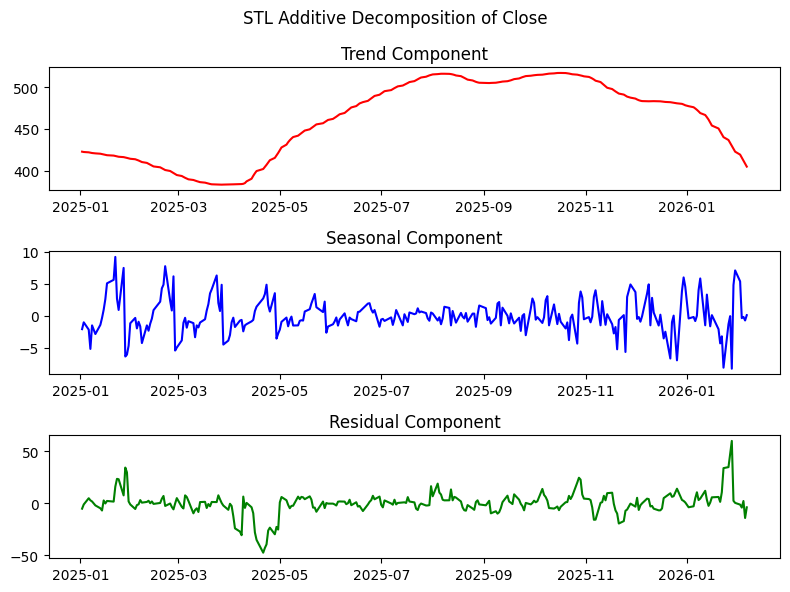

In [ ]:
# additive decomposition is stl - offers freedom to seasonal component
stl = STL(time_df['Close'], period=21, seasonal=101, robust=True)
result = stl.fit()

# Plot the decomposition
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
ax1.plot(result.trend, label='Trend', color='red')
ax1.set_title('Trend Component')
ax2.plot(result.seasonal, label='Seasonal', color='blue')
ax2.set_title('Seasonal Component')
ax3.plot(result.resid, label='Residual', color='green')
ax3.set_title('Residual Component')
plt.suptitle('STL Additive Decomposition of Close')
plt.tight_layout()
plt.show()

In [ ]:
def plot_stl(period, seasonal):
    stl = STL(time_df['Close'], period=period, seasonal=seasonal, robust=True)
    result = stl.fit()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

    ax1.plot(result.trend, color='red')
    ax1.set_title('Trend Component')

    ax2.plot(result.seasonal, color='blue')
    ax2.set_title('Seasonal Component')

    ax3.plot(result.resid, color='green')
    ax3.set_title('Residual Component')

    plt.suptitle('STL Additive Decomposition on Close')
    plt.tight_layout()
    plt.show()

# Slider from 3 to 71
interact(plot_stl, period=widgets.IntSlider(min=3, max=71, step=1, value=21),
         seasonal=widgets.IntSlider(min=7, max=151, step=2, value=21))

interactive(children=(IntSlider(value=21, description='period', max=71, min=3), IntSlider(value=21, descriptio…

<function __main__.plot_stl(period, seasonal)>

In [ ]:
# multiplicative stl decomposition -
# as data has curve in trend, multiplicative decomposition might better
def plot_mstl(period, seasonal):
    stl = STL(np.log(time_df['Close']), period=period, seasonal=seasonal, robust=True)
    result = stl.fit()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

    ax1.plot(result.trend, color='red')
    ax1.set_title('Trend Component')

    ax2.plot(result.seasonal, color='blue')
    ax2.set_title('Seasonal Component')

    ax3.plot(result.resid, color='green')
    ax3.set_title('Residual Component')

    plt.suptitle('STL Multiplicative (log) Decomposition of Close')
    plt.tight_layout()
    plt.show()

# Slider from 3 to 71
interact(plot_mstl, period=widgets.IntSlider(min=3, max=71, step=1, value=21),
         seasonal=widgets.IntSlider(min=3, max=151, step=2, value=21))

interactive(children=(IntSlider(value=21, description='period', max=71, min=3), IntSlider(value=21, descriptio…

<function __main__.plot_mstl(period, seasonal)>

yₜ be forcast of stock close rate.

Tₜ, Sₜ, Rₜ are component from STL decomposition of log data.

log(yₜ)=Tₜ+Sₜ+Rₜ

yₜ = exp(Tₜ+Sₜ+Rₜ)

yₜ = exp(Tₜ) . exp(Sₜ) . exp(Rₜ)

* The stl decomposition of series and log-series shows much weaker seasonality, than classic decomposition, indicates weak seasonal comp in series.
* Log decomp didn't improved the residual or seasonality; suggesting series behaves almost additively and **neglible multiplicative effect**.
* The residual component **dominates the comp** and exhibits spikes and **volatility**, is not a white noise; and imply irregular fluctuation drives the series more than any stable periodic pattern.
* ACF, PACF needed here also for checking further dependence and pattern.

[domain-info] some noises in stock data is normal, comes from daily news, events.

### Stationarity Check
many statistical models assume stationarity.

raw Close price is already non-stationary (has trend).

In [ ]:
# weak stationary test
## augmented dickey fuller - diff based
## null hypothesis; non-stationary (series has root unit)
adf_close = adfuller(time_df['Close'])
adf_rtn = adfuller(time_df['Return'].dropna())

print("Close p-value:", adf_close[1])
print("Return p-value:", adf_rtn[1])

print("\nClose adf stat:", adf_close[0])
print("Return adf stat:", adf_rtn[0])

print('\nCritical Values for Close:')
for key, value in adf_close[4].items():
  print(f'{key}: {round(value, 3)}', end="\t")

print('\nCritical Values for Return:')
for key, value in adf_rtn[4].items():
  print(f'{key}: {round(value, 3)}', end="\t")

Close p-value: 0.7063065189315711
Return p-value: 4.303909797313657e-29

Close adf stat: -1.1217851460067092
Return adf stat: -16.17717376669528

Critical Values for Close:
1%: -3.455	5%: -2.872	10%: -2.572	
Critical Values for Return:
1%: -3.455	5%: -2.872	10%: -2.572	

In [ ]:
# weak stationary test
## kpss test
## null hypothesis: stationary series
kpss_close = kpss(time_df['Close'], 'ct')
kpss_rtn = kpss(time_df['Return'].dropna(), 'ct')

print("Close p-value:", kpss_close[1])
print("Return p-value:", kpss_rtn[1])

print("\nClose adf stat:", kpss_close[0])
print("Return adf stat:", kpss_rtn[0])

print('\nCritical Values for Close:')
for key, value in kpss_close[3].items():
  print(f'{key}: {round(value, 3)}', end="\t")

print('\nCritical Values for Return:')
for key, value in kpss_rtn[3].items():
  print(f'{key}: {round(value, 3)}', end="\t")

Close p-value: 0.01
Return p-value: 0.04462259495229849

Close adf stat: 0.427448328993352
Return adf stat: 0.1524528860572418

Critical Values for Close:
10%: 0.119	5%: 0.146	2.5%: 0.176	1%: 0.216	
Critical Values for Return:
10%: 0.119	5%: 0.146	2.5%: 0.176	1%: 0.216	

/tmp/ipython-input-1766255191.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_close = kpss(time_df['Close'], 'ct')


* Close is non stationary in both ADF (p>0.05) and KPSS (p<0.05) test.
* Return can be almost stationary, as ADF suggest stationary (p and criteria < limit) but KPSS reject null hypothesis (p<0.05 & criteria is in-between values)

In [ ]:
# strict stationary test on return
## ks test
## null hyphothesis: stationary
split = len(time_df['Return'].dropna()) // 2
stat, pvalue = ks_2samp(time_df['Return'].dropna()[0:split],
                        time_df['Return'].dropna()[split:-1])
print(round(pvalue, 3))

0.667


In [ ]:
split = len(time_df['Close'].dropna()) // 2
stat, pvalue = ks_2samp(time_df['Close'].dropna()[0:split],
                        time_df['Close'].dropna()[split:-1])
print(round(pvalue, 3))

0.0


* Return is strict stationary, and Close is not stationary.

### Autocorrelation
correlation of the feature with its own past values

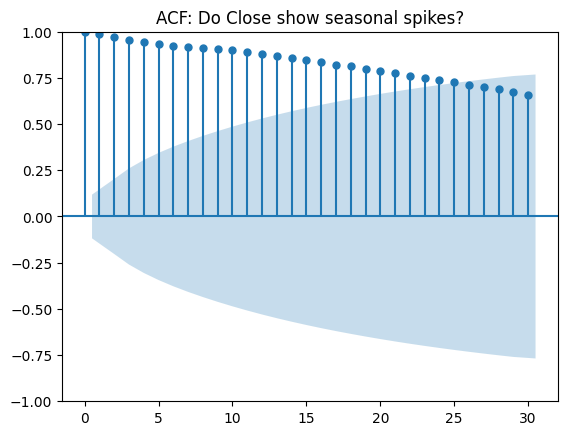

In [ ]:
plot_acf(time_df["Close"].dropna(), lags=30)
plt.title("ACF: Do Close show seasonal spikes?")
plt.show()

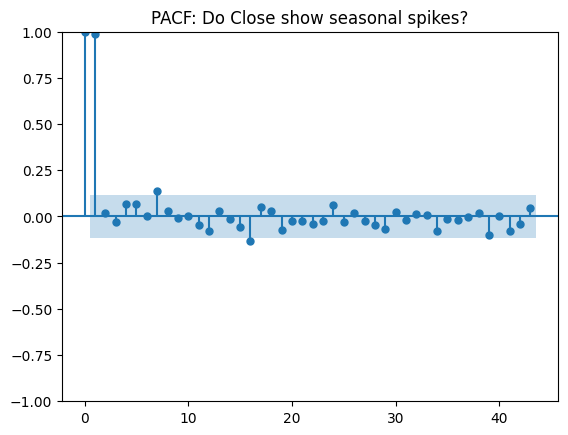

In [ ]:
plot_pacf(time_df["Close"].dropna(), lags=21)
plt.title("ACF: Do Close show seasonal spikes?")
plt.xtick
plt.show()

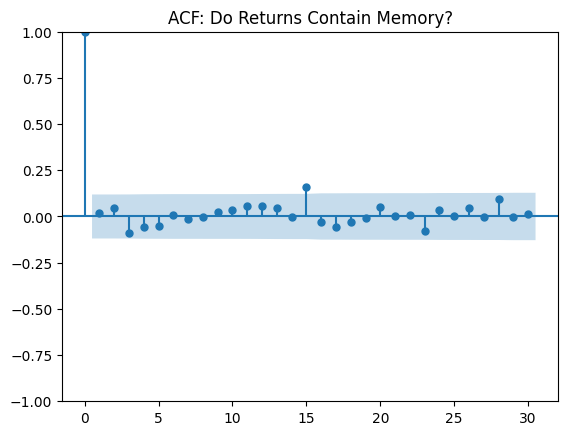

In [ ]:
plot_acf(time_df["Return"].dropna(), lags=30)
plt.title("ACF: Do Returns Contain Memory?")
plt.show()

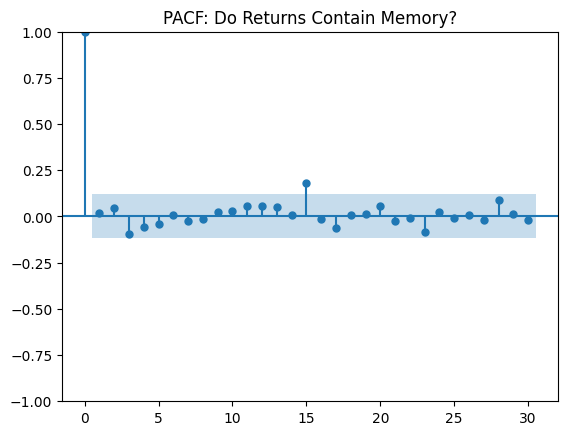

In [ ]:
plot_pacf(time_df["Return"].dropna(), lags=30)
plt.title("PACF: Do Returns Contain Memory?")
plt.show()

* ACF of close shows gradual decay, series with trends and no spikes of seasonality.
* ACF of returns shows no significant autocorrelation, indicating the absence of trend, seasonality, or linear memory in the mean.